In [ ]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ''  # forcing CPU to avoid GPU issues during prediction (uncomment if GPU is not available or causing issues)
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
# tf.config.optimizer.set_jit(False)
print("Devices seen by TF:", tf.config.list_physical_devices())

2025-12-08 23:52:10.959607: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.20.0
Devices seen by TF: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Importing necessary libraries
import shutil
import glob
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# configurations
# path to the dataset directory
BASE_DIR = "/dataset" # change this path as per the directory structure

# train and test directories
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

IMG_HEIGHT, IMG_WIDTH = 48, 48
BATCH_SIZE = 32
NUM_CLASSES = 7

In [ ]:
import cv2
def remove_blank_images(root_dir, low_thr=5, high_thr=250):
    """
    Removing images from root_dir whose mean pixel intensity
    is < low_thr or > high_thr.
    """
    removed_count = 0
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        for fname in os.listdir(class_path):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            fpath = os.path.join(class_path, fname)
            try:
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                mean_val = img.mean()
                if mean_val < low_thr or mean_val > high_thr:
                    os.remove(fpath)
                    removed_count += 1
            except Exception as e:
                print("Error reading/removing:", fpath, e)
    print(f"Removed {removed_count} blank images from {root_dir}.")

# removes blank images from training and testing directories
remove_blank_images(TRAIN_DIR)
remove_blank_images(TEST_DIR)


In [5]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1  # 10% of train for validation
)

# Validation generator
val_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.1
)

# Test data generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    subset='validation'
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_indices = train_gen.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
print("Class indices:", class_indices)

Found 25831 images belonging to 7 classes.
Found 2866 images belonging to 7 classes.
Found 7177 images belonging to 7 classes.
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
#model definition
def build_fer_cnn(input_shape=(48, 48, 1), num_classes=7):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

In [ ]:
# Building and compiling the model
model = build_fer_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), num_classes=NUM_CLASSES)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1765259545.009900  388156 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8129 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:00:10.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,275,111 (4.86 MB)

 Trainable params: 1,273,191 (4.86 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Model size calculation 
total_params = model.count_params()
model_size_mb = (total_params * 4) / (1024 ** 2)  # float32: 4 bytes
print(f"Total parameters: {total_params:,}")
print(f"Approx model size: {model_size_mb:.2f} MB")

Total parameters: 1,275,111
Approx model size: 4.86 MB


In [ ]:
# Setting up callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)
callbacks = [early_stop, reduce_lr]

#training the model
history= model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=200,
    callbacks=callbacks
)
model.save("/model/best_fer_cnn.keras") # saving the trained model

Epoch 1/200


2025-12-08 23:52:33.096217: I external/local_xla/xla/service/service.cc:163] XLA service 0x7246c8002d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-08 23:52:33.096248: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-12-08 23:52:33.269462: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-08 23:52:34.426850: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
2025-12-08 23:52:35.382779: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-08 23:52:35.382854: I e

  5/808 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.1696 - loss: 1.9628 

I0000 00:00:1765259579.723067  388223 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


808/808 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2017 - loss: 1.9119

2025-12-08 23:53:37.541295: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-08 23:53:37.541686: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-08 23:53:39.417029: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_325', 20 bytes spill stores, 20 bytes spill loads

2025-12-08 23:53:39.790201: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

808/808 ━━━━━━━━━━━━━━━━━━━━ 87s 67ms/step - accuracy: 0.2145 - loss: 1.8733 - val_accuracy: 0.2509 - val_loss: 1.8610 - learning_rate: 1.0000e-04
Epoch 2/200
808/808 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.2380 - loss: 1.8191 - val_accuracy: 0.2561 - val_loss: 1.9060 - learning_rate: 1.0000e-04
Epoch 3/200
808/808 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.2564 - loss: 1.7920 - val_accuracy: 0.2523 - val_loss: 1.9056 - learning_rate: 1.0000e-04
Epoch 4/200
808/808 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.2754 - loss: 1.7645 - val_accuracy: 0.2715 - val_loss: 1.8978 - learning_rate: 1.0000e-04
Epoch 5/200
808/808 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.2978 - loss: 1.7334 - val_accuracy: 0.3367 - val_loss: 1.6632 - learning_rate: 1.0000e-04
Epoch 6/200
808/808 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.3211 - loss: 1.7000 - val_accuracy: 0.3716 - val_loss: 1.5929 - learning_rate: 1.0000e-04
Epoch 7/200
808/808 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - a

In [ ]:
# Function to plot training history
import matplotlib.pyplot as plt
import numpy as np

def plot_model_history(model_history):

    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    axs[0].plot(epochs, acc, label='Train Accuracy')
    axs[0].plot(epochs, val_acc, label='Val Accuracy')
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')

    # Reducing the number of ticks for readability
    axs[0].xaxis.set_major_locator(plt.MaxNLocator(10))

    axs[0].grid(True, linestyle='--', alpha=0.5)
    axs[0].legend()

    # Loss plot
    axs[1].plot(epochs, loss, label='Train Loss')
    axs[1].plot(epochs, val_loss, label='Val Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')

    axs[1].xaxis.set_major_locator(plt.MaxNLocator(10))

    axs[1].grid(True, linestyle='--', alpha=0.5)
    axs[1].legend()

    fig.tight_layout()
    fig.savefig('plot.png')
    plt.show()


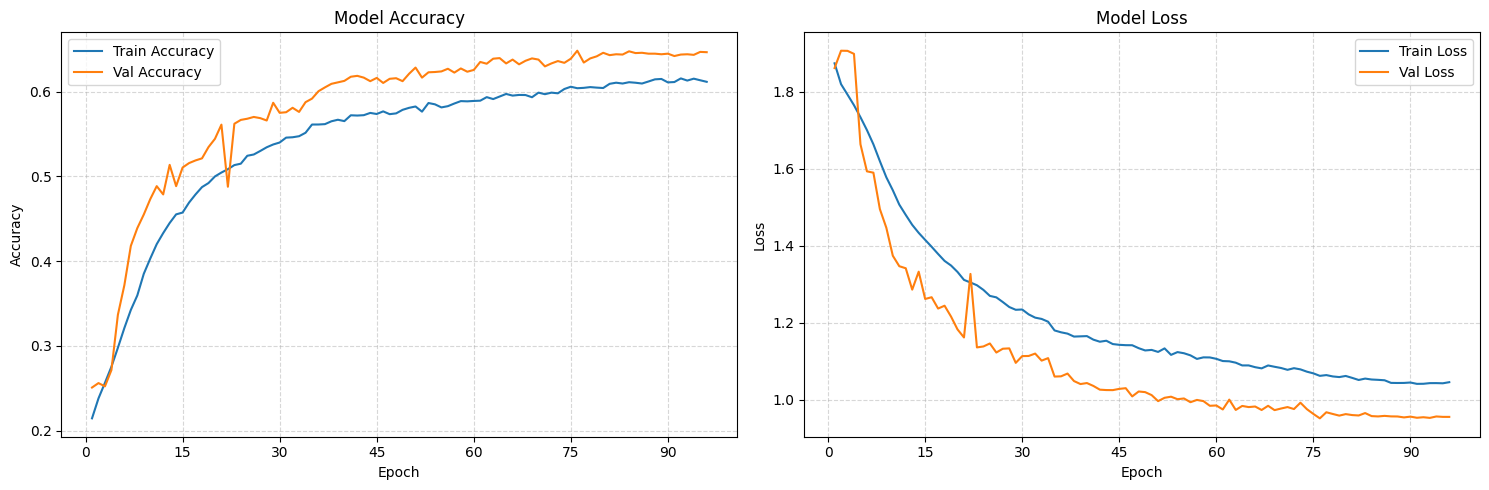

In [ ]:
# Plotting the model history
plot_model_history(history)